In [106]:
import geopandas as gpd
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
import copy 

warnings.filterwarnings('ignore')
tqdm.pandas()

## Load Roads

In [2]:
MAPA_PATH = "../../../data/Mapa/Ben Gurion University/Gisrael/"

In [30]:
roads_df = gpd.read_file(MAPA_PATH + 'is_str.shp')

In [31]:
roads_df = roads_df.set_index('UserID')

In [32]:
roads_df.head(1)

,street,FromLeft,ToLeft,FromRight,ToRight,StreetCode,ObjID,FJunction,TJunction,Length,...,Status,RoadFuncti,Flag,Identifier,Roaddirect,CLEARSTREE,REVERSTREE,CLEARCITYN,REVERCITYN,geometry
UserID,,,,,,,,,,,,,,,,,,,,,
1004561,None,0,0,0,0,None,1,947733,947736,64.569179,...,Operative,4x4 Road,5,1012284,222222,None,None,àéìú,úìéà,"LINESTRING (194289.114 388953.679, 194277.535 ..."


In [33]:
print('Number of edges (links) in networks: ' + str(roads_df.shape[0]))

Number of edges (links) in networks: 647504


In [34]:
unique_junctions = roads_df['FJunction'].append(roads_df['TJunction']).unique()

In [35]:
print('Number of nodes (junctions) in networks: ' + str(unique_junctions.shape[0]))

Number of nodes (junctions) in networks: 489961


In [36]:
num_orogins = roads_df['FJunction'].unique().shape[0]
print('Number of unique link origins: ' + str(num_orogins))
print('This means an average out-degree of ' + str(roads_df.shape[0] / num_orogins))

Number of unique link origins: 438984
This means an average out-degree of 1.4750059227671168


In [37]:
num_targets = roads_df['TJunction'].unique().shape[0]
print('Number of unique link targets: ' + str(num_targets))
print('This means an average in-degree of ' + str(roads_df.shape[0] / num_targets))

Number of unique link targets: 456354
This means an average in-degree of 1.418863426199836


### Get Edges (based on one-way and two-way roads) 

In [38]:
roads_df.columns

Index(['street', 'FromLeft', 'ToLeft', 'FromRight', 'ToRight', 'StreetCode',
       'ObjID', 'FJunction', 'TJunction', 'Length', 'RoadType', 'OneWay',
       'F_ZLev', 'T_ZLev', 'FLanes', 'TLanes', 'Intended', 'cityname',
       'CityCode', 'Seconds', 'FromSpeedL', 'ToSpeedL', 'AprxSpeedL',
       'Autonomy', 'Regulation', 'RoadNameMZ', 'DirectionM', 'Status',
       'RoadFuncti', 'Flag', 'Identifier', 'Roaddirect', 'CLEARSTREE',
       'REVERSTREE', 'CLEARCITYN', 'REVERCITYN', 'geometry'],
      dtype='object')

In [39]:
shape_edges_df = roads_df[['ObjID', 'FJunction', 'TJunction', 'RoadType', 
                     'OneWay', 'FromSpeedL', 'ToSpeedL', 
                     'AprxSpeedL', 'Seconds', 'Length', 'Roaddirect', 'DirectionM']]
shape_edges_df = shape_edges_df.reset_index()

In [40]:
shape_edges_df.head(2)

,UserID,ObjID,FJunction,TJunction,RoadType,OneWay,FromSpeedL,ToSpeedL,AprxSpeedL,Seconds,Length,Roaddirect,DirectionM
0,1004561,1,947733,947736,254,2,10,10,10,69.734908,64.569179,222222,None
1,1059914,2,950536,983821,10,2,90,90,90,2.249966,49.999104,222222,B


In [75]:
edges_df = pd.DataFrame(columns=shape_edges_df.columns)
edges_df.head()

,UserID,ObjID,FJunction,TJunction,RoadType,OneWay,FromSpeedL,ToSpeedL,AprxSpeedL,Seconds,Length,Roaddirect,DirectionM


In [69]:
shape_edges_df['OneWay'].unique()

array(['2', 'ft', 'N', 'tf'], dtype=object)

In [86]:
shape_edges_df.head()

,UserID,ObjID,FJunction,TJunction,RoadType,OneWay,FromSpeedL,ToSpeedL,AprxSpeedL,Seconds,Length,Roaddirect,DirectionM
0,1004561,1,947733,947736,254,2,10,10,10,69.734908,64.569179,222222,None
1,1059914,2,950536,983821,10,2,90,90,90,2.249966,49.999104,222222,B
2,1060654,3,17832,984255,10,2,90,90,90,72.570183,1612.666216,222222,B
3,967162,4,912962,911713,254,2,10,10,10,453.304152,419.724891,222222,None
4,1326304,5,1141238,892364,6,2,50,50,50,5.849229,44.681484,222222,None


In [197]:
edges_dict = dict()
adjacency_list = dict()
number_of_two_way = 0
number_of_ft = 0
number_of_tf = 0

def create_edges_dict(e):
    global edges_dict
    global number_of_two_way
    global number_of_ft
    global number_of_tf
    
    road_type = e['OneWay']
    frm = str(e['FJunction'])
    to = str(e['TJunction'])
    
    if road_type == 'N':
        return
    elif road_type == 'ft':
        edges_dict[frm, to] = copy.deepcopy(e)
        
        if frm not in adjacency_list:
            adjacency_list[frm] = dict()
        adjacency_list[frm][to] = copy.deepcopy(e)
        
        number_of_ft += 1
    elif road_type == 'tf':
        edges_dict[to, frm] = copy.deepcopy(e)
        
        if to not in adjacency_list:
            adjacency_list[to] = dict()
        adjacency_list[to][frm] = copy.deepcopy(e)
        
        number_of_tf += 1
    elif road_type == '2':
        edges_dict[frm, to] = copy.deepcopy(e)
        edges_dict[to, frm] = copy.deepcopy(e)
        
        if frm not in adjacency_list:
            adjacency_list[frm] = dict()
        adjacency_list[frm][to] = copy.deepcopy(e)
        
        if to not in adjacency_list:
            adjacency_list[to] = dict()
        adjacency_list[to][frm] = copy.deepcopy(e)
        
        number_of_two_way +=2
        
shape_edges_df.progress_apply(lambda x: create_edges_dict(x), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
647499    None
647500    None
647501    None
647502    None
647503    None
Length: 647504, dtype: object

In [198]:
original_adjacency_list = adjacency_listjacency_list.copy()

In [91]:
len(edges_dict)

859377

In [93]:
# Sanity check
number_of_edges = len(edges_dict)
number_of_ft = shape_edges_df[shape_edges_df['OneWay'] == 'ft'].shape[0]
number_of_tf = shape_edges_df[shape_edges_df['OneWay'] == 'tf'].shape[0]
number_of_two_way = shape_edges_df[shape_edges_df['OneWay'] == '2'].shape[0]
print(number_of_edges)
print(f'number of ft: {number_of_ft}, number of tf: {number_of_tf}, number of two ways * 2: {number_of_two_way*2}')
assert number_of_edges == (number_of_ft + number_of_tf + number_of_two_way*2)

859377
number of ft: 154969, number of tf: 24314, number of two ways * 2: 680094


In [95]:
# Save edges
edges_df.to_pickle('../../output_data/road_edges.pkl')

with open('../../output_data/road_edges.pkl', 'wb') as f:
    pickle.dump(edges_dict, f)


### First Stage - without turn restrictions

In [99]:
# Get out degrees
unique_origins_count_df = roads_df['FJunction'].value_counts()
unique_origins_df = pd.DataFrame()
unique_origins_df['id'] = unique_origins_count_df.index
unique_origins_df['out_degree'] = unique_origins_count_df.values

In [100]:
# Get in degrees
unique_targets_count_df = roads_df['TJunction'].value_counts()
unique_targets_df = pd.DataFrame()
unique_targets_df['id'] = unique_targets_count_df.index
unique_targets_df['in_degree'] = unique_targets_count_df.values

In [101]:
# Create basic nodes with in and out degrees
nodes_df = pd.DataFrame()
nodes_df['id'] = pd.Series(unique_junctions)
nodes_df = nodes_df.merge(unique_origins_df, how='left', on='id')
nodes_df = nodes_df.merge(unique_targets_df, how='left', on='id')
nodes_df = nodes_df.fillna(0)

In [102]:
nodes_df.head()

,id,out_degree,in_degree
0,947733,1.0,1.0
1,950536,1.0,1.0
2,17832,2.0,1.0
3,912962,2.0,0.0
4,1141238,1.0,1.0


In [104]:
nodes_df.shape

(489961, 3)

__Find "middle" nodes (one link enters, one link leaves)__ <br>
Next we'll need to see if "both sides" of the node are similar: same type (one-way/two-way), same speed

In [109]:
middle_nodes_df = nodes_df[nodes_df['in_degree'] == 1][nodes_df['out_degree'] == 1]

In [115]:
middle_nodes_df.head()

,id,out_degree,in_degree
0,947733,1.0,1.0
1,950536,1.0,1.0
4,1141238,1.0,1.0
6,929680,1.0,1.0
7,983803,1.0,1.0


In [116]:
roads_df.columns

Index(['street', 'FromLeft', 'ToLeft', 'FromRight', 'ToRight', 'StreetCode',
       'ObjID', 'FJunction', 'TJunction', 'Length', 'RoadType', 'OneWay',
       'F_ZLev', 'T_ZLev', 'FLanes', 'TLanes', 'Intended', 'cityname',
       'CityCode', 'Seconds', 'FromSpeedL', 'ToSpeedL', 'AprxSpeedL',
       'Autonomy', 'Regulation', 'RoadNameMZ', 'DirectionM', 'Status',
       'RoadFuncti', 'Flag', 'Identifier', 'Roaddirect', 'CLEARSTREE',
       'REVERSTREE', 'CLEARCITYN', 'REVERCITYN', 'geometry'],
      dtype='object')

In [117]:
middle_nodes_df = middle_nodes_df.merge(roads_df, how='left', left_on='id', right_on='FJunction')

In [118]:
middle_nodes_df.head(2)

,id,out_degree,in_degree,street,FromLeft,ToLeft,FromRight,ToRight,StreetCode,ObjID,...,Status,RoadFuncti,Flag,Identifier,Roaddirect,CLEARSTREE,REVERSTREE,CLEARCITYN,REVERCITYN,geometry
0,947733,1.0,1.0,None,0,0,0,0,None,1,...,Operative,4x4 Road,5,1012284,222222,None,None,àéìú,úìéà,"LINESTRING (194289.114 388953.679, 194277.535 ..."
1,950536,1.0,1.0,40,0,0,0,0,None,2,...,Operative,Major Road,1,0,222222,40,40,îöôäøîåï,ïåîø äôöî,"LINESTRING (187484.184 501340.215, 187506.545 ..."


In [119]:
middle_nodes_df = middle_nodes_df.merge(roads_df, how='left', left_on='id', right_on='TJunction', suffixes=('_before','_after'))

## Explore Turn Restrictions

In [3]:
turn_restrict_df = gpd.read_file(MAPA_PATH + 'restrict.shp')

In [5]:
turn_restrict_df = turn_restrict_df.drop(['permission', 'descriptio', 'geometry'], axis=1)

In [6]:
turn_restrict_df.head()

,objid,userid,einterval,junctionid,xinterval
0,1,290963,1186054,1058686,1186052
1,2,333770,1449582,1218598,1449582
2,3,140163,1108991,1014949,1108987
3,4,145069,1727739,1038715,1727739
4,5,116673,1537902,45643,1537902


In [15]:
turn_restrict_df.shape

(72004, 5)

In [98]:
middle_node_value_counts = turn_restrict_df['junctionid'].value_counts()

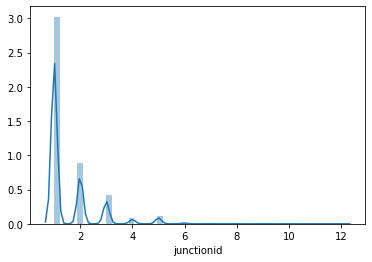

In [99]:
sns.distplot(middle_node_value_counts);

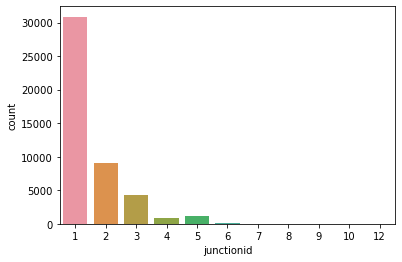

In [100]:
sns.countplot(middle_node_value_counts);

In [101]:
middle_node_value_counts.value_counts()

1     30873
2      9111
3      4289
5      1125
4       822
6       142
7        20
8         7
10        3
9         3
12        2
Name: junctionid, dtype: int64

## Util Functions

In [194]:
def get_edge_other_node(edge_id, node):
    e = shape_edges_df[shape_edges_df['UserID'] == edge_id]
    
    f = e['FJunction'].values[0]
    t = e['TJunction'].values[0]
    
    if f == node:
        return t
    if t == node:
        return f
    
    raise Exception(f'node {node} is not part of the edge {edge_id}')

In [195]:
# Test: This should return 1058685
get_edge_other_node(1186054, 1058686)

1058685

## Apply turn restrictions algorithm

In [97]:
turn_restrict_df.head()

,objid,userid,einterval,junctionid,xinterval
0,1,290963,1186054,1058686,1186052
1,2,333770,1449582,1218598,1449582
2,3,140163,1108991,1014949,1108987
3,4,145069,1727739,1038715,1727739
4,5,116673,1537902,45643,1537902


In [130]:
turn_restrict_df.shape

(72004, 5)

In [180]:
shape_edges_df = shape_edges_df.reset_index()

In [205]:
adjacency_list = original_adjacency_list.copy()

In [206]:
skipped_restrictions = []
for i, restrict in turn_restrict_df.iterrows():
    u = str(get_edge_other_node(restrict['einterval'], restrict['junctionid']))
    v = str(restrict['junctionid'])
    w = str(get_edge_other_node(restrict['xinterval'], restrict['junctionid']))
    
    # if no edge (u,v) or (v,w) then the restriction is already enforced
    if ((u not in adjacency_list) or (v not in adjacency_list[u]) or 
        (v not in adjacency_list) or (w not in adjacency_list[v])):
        skipped_restrictions.append(restrict)
        continue
        
    # add a new node v_u with a new edge (u, v_u)
    v_u = v + '_' + u
    adjacency_list[v_u] = dict()
    adjacency_list[u][v_u] = adjacency_list[u][v]
    
    # remove (u,v)
    del adjacency_list[u][v]
    
    
    # for each edge (v,x) where x!=w add (v_u, x)
    for x in adjacency_list[v]:
        if x == w:
            continue
        adjacency_list[v_u][x] = adjacency_list[v][x]
        
print(f'Skipped {len(skipped_restrictions)} restrictions')

Skipped 72004 restrictions


<span style="background-color: #FFFF00">We must figure out why we skipped some restrictions</span>

In [203]:
num_edges = 0
for s, targets in adjacency_list.items():
    for t in targets:
        num_edges += 1
        
print(f'The number of edges after turn restriction manipulation is {num_edges}')

The number of edges after turn restriction manipulation is 859377


In [125]:
print(f'The number of edges before turn restriction manipulation was {len(edges_dict)}')

The number of edges before turn restriction manipulation was 859377


In [201]:
num_new_edges = 0
for s, targets in adjacency_list.items():
    if '_' not in s:
        # we don't care about 'regular' source nodes, only newly added
        continue
    for t in targets:
        num_new_edges += 1
        
print(f'The number of NEW edges after turn restriction manipulation is {num_new_edges}')

The number of NEW edges after turn restriction manipulation is 76602


### Let's check why turn restrictions are being skipped

In [96]:
shape_edges_df.head()

,UserID,ObjID,FJunction,TJunction,RoadType,OneWay,FromSpeedL,ToSpeedL,AprxSpeedL,Seconds,Length,Roaddirect,DirectionM
0,1004561,1,947733,947736,254,2,10,10,10,69.734908,64.569179,222222,None
1,1059914,2,950536,983821,10,2,90,90,90,2.249966,49.999104,222222,B
2,1060654,3,17832,984255,10,2,90,90,90,72.570183,1612.666216,222222,B
3,967162,4,912962,911713,254,2,10,10,10,453.304152,419.724891,222222,None
4,1326304,5,1141238,892364,6,2,50,50,50,5.849229,44.681484,222222,None


In [134]:
a = shape_edges_df[shape_edges_df['FJunction'] == 0]
a.empty

True

In [145]:
def does_edge_exist(a, b):
    ab = shape_edges_df[shape_edges_df['FJunction'] == a][shape_edges_df['TJunction'] == b]
    if not ab.empty:
        # Verify it's ft or two-way
        if ab.reset_index()[0]['OneWay'] == 'tf':
            return False
        return True
    
    ab = shape_edges_df[shape_edges_df['TJunction'] == a][shape_edges_df['FJunction'] == b]
    if not ab.empty:
        # Verify it's tf or two-way
        if ab.reset_index()[0]['OneWay'] == 'ft':
            return False
        return True
    
    return False

In [146]:
does_edge_exist(1186054, 1058686)

False

In [ ]:
shape_edges_df[shape_edges_df['FJunction'] == a][shape_edges_df['TJunction'] == b]

In [148]:
uv_skipped = 0
vw_skipped = 0
should_handle = 0
for i, restrict in turn_restrict_df.iterrows():
    u = restrict['einterval']
    v = restrict['junctionid']
    w = restrict['xinterval']
    
    uv_exists = does_edge_exist(u,v)
    vw_exists = does_edge_exist(v,w)
    if not uv_exists:
        uv_skipped += 1
        
    if not vw_exists:
        vw_skipped += 1
        
    if uv_exists and vw_exists:
        print(should_handle)
        
print(f'Skipped {uv_skipped} (u,v) edges and {vw_skipped} (v,w) edges')          
            
    
        

KeyError: 0